In [281]:
import pandas as pd
from sklearn.metrics.cluster import v_measure_score
import random
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
import numpy as np

In [282]:
random.seed(42)

In [283]:
dataset_name = 'breast_cancer_coimbra'
dataset_test_path = f'./data/{dataset_name}-train.csv'
dataset_train_path = f'./data/{dataset_name}-test.csv'
df_train = pd.read_csv(dataset_train_path)
df_test = pd.read_csv(dataset_test_path)

X_train = df_train.drop(columns=['Classification']).to_numpy()
y_train = df_train['Classification'].to_numpy()
X_test = df_test.drop(columns=['Classification']).to_numpy()
y_test = df_test['Classification'].to_numpy()

n_features = X_train.shape[1]

In [284]:
import math
x = [1, 2, 3, 4, 5]
result = eval("math.log(x[3])", {"math": math, "x": x})
print(result)  # Output: 1.4142135623730951

1.3862943611198906


In [285]:
math.fabs(-1)

1.0

In [286]:
class SafeMath:
    @staticmethod
    def divide(a, b):
        return a / 0.0000000001 if b == 0 else a / b
    @staticmethod
    def log(x):
        if x == 0:
            x += 0.0000000001
        return math.log(abs(x)) 
    @staticmethod
    def sqrt(x):
        return math.sqrt(abs(x))
    @staticmethod
    def pow2(x):
        return x * x
    @staticmethod
    def inv(x):
        if(x == 0):
            x += 0.0000000001
        return 1 / x
    

In [287]:
RANGE_CONST = 10
NIVEIS_RECURSAO = 2
terminais = ["+", "-", "*", "/", "SafeMath.log", "SafeMath.sqrt", "SafeMath.pow2", "SafeMath.inv", "(", ")"] \
            + [str(i) for i in range(1, RANGE_CONST)] \
            + [f"dx[{i}]" for i in range(n_features)]
naoterminais = ["<S>", "<E>", "<OP>", "<POP>", "<VAR>", "<CONST>"] + [f"<E_{i}>" for i in range(NIVEIS_RECURSAO)]
gramatica = {
    "<S>" : [["<E>"]],
    "<OP>" : [["+"], ["-"], ["*"]],
    "<E>" : [["<E_0>", "<OP>", "<E_0>"], ["<POP>", "(", "<E_0>", ")"], ["<VAR>"]],
    "<POP>" : [["SafeMath.log"], ["SafeMath.sqrt"], ["SafeMath.pow2"], ["SafeMath.inv"], ["<CONST>", "*"]],
    "<CONST>" : [[str(i)] for i in range(1, RANGE_CONST)],
    "<VAR>" : [[f"dx[{i}]"]  for i in range(n_features)]
}
#    
for i in range(NIVEIS_RECURSAO - 1):
    gramatica[f'<E_{i}>'] = [[f"<E_{i+1}>", "<OP>", f"<E_{i+1}>"], ["<POP>", "(", f"<E_{i+1}>", ")"], \
                             ["<VAR>"]]
gramatica[f'<E_{NIVEIS_RECURSAO-1}>'] = [["<VAR>", "<OP>", "<VAR>"], \
                                       ["<POP>", "(", "<VAR>", ")"], \
                                       ["<VAR>"]]
# gramatica

In [288]:
class NoArvore:
    def __init__(self, chave : str):
        self.chave = chave
        self.filhos = []
    
    def adicionarFilhos(self, filhos: list['NoArvore']):
        self.filhos = filhos

class Arvore:
    def __init__(self, raiz : NoArvore):
        self.raiz = raiz
    def getExpressao(self):
        folhas = []
        self._getExpressaoRecursivo(self.raiz, folhas)
        return ''.join(folhas)

    def _getExpressaoRecursivo(self, no: NoArvore, folhas: list):
        if no is None:
            return 
        # Se o nó não tem filhos, é uma folha
        if not no.filhos:
            folhas.append(no.chave)
        else:
            # Percorre recursivamente cada filho
            for filho in no.filhos:
                self._getExpressaoRecursivo(filho, folhas)

In [289]:
ids_expansao = {}
genotipo = {}
for nao_terminal in gramatica.keys():
    ids_expansao[nao_terminal] = 0
    genotipo[nao_terminal] = [0 for _ in range(10)]
genotipo["<S>"] = [0]
genotipo["<E>"] = [0]
genotipo["<E_0>"] = [2, 0]
genotipo["<E_1>"] = [2, 2]
genotipo["<OP>"] = [0, 2]
genotipo["<VAR>"] = [0, 1, 2]


In [290]:
raiz = NoArvore("<S>")
arvore = Arvore(raiz)
fronteira = ["<S>"]
ind_no_a_expandir = 0

while ind_no_a_expandir < len(fronteira):
    if fronteira[ind_no_a_expandir] in terminais:    
        ind_no_a_expandir += 1
        continue
    no_nao_terminal = fronteira[ind_no_a_expandir]
    nao_terminal = no_nao_terminal
    ind_producao = genotipo[nao_terminal][ids_expansao[nao_terminal]]
    ids_expansao[nao_terminal] += 1
    producao = gramatica[nao_terminal][ind_producao]
    fronteira.pop(ind_no_a_expandir)
    fronteira = fronteira[:ind_no_a_expandir] + producao + fronteira[ind_no_a_expandir:]

print(fronteira)
print(''.join(fronteira))


['dx[0]', '+', 'dx[1]', '*', 'dx[2]']
dx[0]+dx[1]*dx[2]


In [291]:
class Individuo():
    def __init__(self, genotipo = None):
        if(genotipo is not None):
            self.genotipo = genotipo
            self.fenotipo = self.calcular_fenotipo()
            return
        
        self.genotipo = {}
        self.genotipo["<S>"] = [0]
        self.genotipo["<E>"] = [random.randint(0, len(gramatica["<E>"]) - 1)]
        for i in range(NIVEIS_RECURSAO):
            self.genotipo[f"<E_{i}>"] = [random.randint(0, len(gramatica[f"<E_{i}>"]) - 1) for _ in range(2**(i+1))]
        self.genotipo["<OP>"] = [random.randint(0, len(gramatica["<OP>"]) - 1) for _ in range(2**(NIVEIS_RECURSAO + 1))]
        self.genotipo["<POP>"] = [random.randint(0, len(gramatica["<POP>"]) - 1) for _ in range(2**(NIVEIS_RECURSAO + 1))]
        self.genotipo["<VAR>"] = [random.randint(0, len(gramatica["<VAR>"]) - 1) for _ in range(2**(NIVEIS_RECURSAO + 1))]
        self.genotipo["<CONST>"] = [random.randint(0, len(gramatica["<CONST>"]) - 1) for _ in range(2**(NIVEIS_RECURSAO + 1))]
        
        self.fenotipo = self.calcular_fenotipo()

    def calcular_fenotipo(self):
        ids_expansao = {}
        for nao_terminal in gramatica.keys():
            ids_expansao[nao_terminal] = 0
        fronteira = ["<S>"]
        ind_no_a_expandir = 0

        while ind_no_a_expandir < len(fronteira):
            if fronteira[ind_no_a_expandir] in terminais:    
                ind_no_a_expandir += 1
                continue
            no_nao_terminal = fronteira[ind_no_a_expandir]
            nao_terminal = no_nao_terminal
            if(ids_expansao[nao_terminal] >= len(self.genotipo[nao_terminal])):
                print(f"Erro : {nao_terminal} - {ids_expansao[nao_terminal]} - len: {len(self.genotipo[nao_terminal])}")                
            ind_producao = self.genotipo[nao_terminal][ids_expansao[nao_terminal]]
            ids_expansao[nao_terminal] += 1
            producao = gramatica[nao_terminal][ind_producao]
            fronteira.pop(ind_no_a_expandir)
            fronteira = fronteira[:ind_no_a_expandir] + producao + fronteira[ind_no_a_expandir:]
        return ''.join(fronteira)
    
    def fazer_mutacao(self):
        terminal_aleatorio = random.choice(list(gramatica.keys()))
        lista = self.genotipo[terminal_aleatorio]
        indice_aleatorio = random.randint(0, len(lista) - 1)
        producao_aleatoria = random.randint(0, len(gramatica[terminal_aleatorio]) - 1)
        self.genotipo[terminal_aleatorio][indice_aleatorio] = producao_aleatoria
        self.fenotipo = self.calcular_fenotipo()

    def calcular_distancia(self, xi, xj):
        dx = abs(xi - xj)
        return eval(self.fenotipo, {"math": math, "dx": dx, "SafeMath": SafeMath})
    

    def fitness(self, X, y):
        n_instancias = len(X)
        n_labels = len(set(y)) 
        matriz_distancias = np.zeros((n_instancias, n_instancias))
        for i in range(n_instancias):
            for j in range(n_instancias):
                distancia = self.calcular_distancia(X[i], X[j])
                matriz_distancias[i][j] = matriz_distancias[j][i] = distancia
        clustering = AgglomerativeClustering(
        n_clusters=n_labels,   
        metric='precomputed', 
        linkage='complete' 
        )
        labels = clustering.fit_predict(matriz_distancias)
        return v_measure_score(y, labels) 

In [292]:
ind = Individuo()
dx = [1, 2, 3, 4, 5, 6,7, 8, 9, 10]
print(ind.fenotipo)
eval(ind.fenotipo)

dx[0]


1

In [293]:
class Populacao():
    def __init__(self, n_pop, pc, pm, tam_torneio, X, y, eh_elitismo = False):
        self._populacao : list[tuple[Individuo, int]] = []
        self._n_pop = n_pop
        self._pc = pc
        self._pm = pm
        self._tam_torneio = tam_torneio
        self._eh_elitismo = eh_elitismo
        self._X = X
        self._y = y
        self.gerar_pop_inicial()
    
    def gerar_pop_inicial(self):
        for _ in range(self._n_pop):
            ind = Individuo()
            self._populacao.append((ind, ind.fitness(self._X, self._y)))
    
    def cruzamento(self, pai1, pai2):
        genotipo_filho = {}
        for key in pai1.genotipo.keys():
            if(random.random() < 0.5):
                genotipo_filho[key] = pai1.genotipo[key]
            else:
                genotipo_filho[key] = pai2.genotipo[key]
        return Individuo(genotipo_filho)
    
    def escolher_pais(self):
        pai1 = self._populacao[random.randint(0, self._n_pop - 1)]
        while True:
            pai2 = self._populacao[random.randint(0, self._n_pop - 1)]
            if pai1 != pai2:
                break
        return pai1, pai2

    def gerar_filhos(self):
        n_filhos = 0
        n_filhos_melhores_que_pais = 0
        while(n_filhos < self._n_pop):
            pai1, pai2 = self.escolher_pais()
            if(random.random() < self._pc):
                filho = self.cruzamento(pai1[0], pai2[0])
                fitness_filho = filho.fitness(self._X, self._y)
                if(fitness_filho > ((pai1[1] +  pai2[1])/2)):
                    n_filhos_melhores_que_pais += 1
            else:
                filho = pai1[0]
            if(random.random() < self._pm):
                filho.fazer_mutacao()
            self._populacao.append((filho, filho.fitness(self._X, self._y)))
            n_filhos += 1
        print(f"Filhos melhores que pais: {n_filhos_melhores_que_pais}")
        
    def fazer_selecao(self):
        nova_pop = []
        if(self._eh_elitismo):
            best_fitness = self._populacao[0][1]
            ind_best = 0
            for i in range(len(self._populacao)):
                if(self._populacao[i][1] > best_fitness):
                    best_fitness = self._populacao[i][1]
                    ind_best = i
            nova_pop.append(self._populacao[ind_best])
            self._populacao.pop(ind_best)
        while(len(nova_pop) < self._n_pop):
            torneio : list[int] = []
            while(len(torneio) < self._tam_torneio):
                indice_aleatorio = random.randint(0, len(self._populacao) - 1)
                if(indice_aleatorio not in torneio):
                    torneio.append(indice_aleatorio)
            ind_vencedor = 0
            for i in range(1, len(torneio)):
                if(self._populacao[torneio[i]][1] > self._populacao[torneio[ind_vencedor]][1]):
                    ind_vencedor = i  
            nova_pop.append(self._populacao[ind_vencedor])
            self._populacao.pop(ind_vencedor)
        self._populacao = nova_pop
        if(self._eh_elitismo and (self._populacao[0][1] != nova_pop[0][1])):
            print(f"Erro elitismo: {self._populacao[0][1]} != {nova_pop[0][1]}")
    

    def get_fitness_media(self):
        return sum([x[1] for x in self._populacao]) / self._n_pop
    
    def get_melhor_individuo(self) -> tuple[Individuo, int]:
        ind_melhor = 0
        for i, (_, fitness) in enumerate(self._populacao):
            if fitness > self._populacao[ind_melhor][1]:
                ind_melhor = i
        return self._populacao[ind_melhor]
    
    def get_pior_individuo(self) -> tuple[Individuo, int]:
        ind_pior = 0
        for i, (_, fitness) in enumerate(self._populacao):
            if fitness < self._populacao[ind_pior][1]:
                ind_pior = i
        return self._populacao[ind_pior]
    
    def get_distribuicao_pop(self):
        distribuicao = {}
        for (ind, fitness) in self._populacao:
            if ind.fenotipo not in distribuicao:
                distribuicao[ind.fenotipo] = 1
            else:
                distribuicao[ind.fenotipo] += 1
        return distribuicao

    def get_tam_pop(self):
        return len(self._populacao)

    

In [294]:
N_GERACOES = 100
N_POP = 50
PC = 0.9
PM = 0.05
TAM_TORNEIO = 2
EH_ELITISMO = True
N_RUNS = 1
arr_piores_fitness = []
arr_melhores_fitness = []
arr_fitness_media = []
arr_num_individuos_diferentes = []
#for _ in range(N_RUNS):
pop = Populacao(N_POP, PC, PM, TAM_TORNEIO, X_train, y_train, eh_elitismo = EH_ELITISMO)
for i in range(N_GERACOES):
    pop.gerar_filhos()
    pop.fazer_selecao()
    print(f'Geração {i} - Fitness médio: {pop.get_fitness_media()}')
    print(f'Melhor indivíduo: {pop.get_melhor_individuo()[0].fenotipo} - Fitness: {pop.get_melhor_individuo()[1]}')
    """ print(f"Pior indivíduo: {pop.get_pior_individuo()[0].fenotipo} - Fitness: {pop.get_pior_individuo()[1]}")
    print(f"tamanho pop: {pop.get_tam_pop()}")
    print(f"Tamanho indivíduos diferentes: {len(pop.get_distribuicao_pop())}") """
    print("-"*20)
    arr_piores_fitness.append(pop.get_pior_individuo()[1])
    arr_melhores_fitness.append(pop.get_melhor_individuo()[1])
    arr_fitness_media.append(pop.get_fitness_media())
    arr_num_individuos_diferentes.append(len(pop.get_distribuicao_pop()))

Filhos melhores que pais: 17
Geração 0 - Fitness médio: 0.10293165684350336
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
--------------------
Filhos melhores que pais: 22
Geração 1 - Fitness médio: 0.10293165684350336
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
--------------------
Filhos melhores que pais: 15
Geração 2 - Fitness médio: 0.09840572192652752
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
--------------------
Filhos melhores que pais: 15
Geração 3 - Fitness médio: 0.10081696660227327
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
--------------------
Filhos melhores que pais: 14
Geração 4 - Fitness médio: 0.10081696660227327
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
--------------------
Filhos melhores que pais: 13
Geração 5 - Fitness médio: 0.10081696660227324
Melhor indivíduo: dx[3]-1*(dx[7]-dx[2]) - Fitness: 0.34371101848545055
-------------

KeyboardInterrupt: 

In [ ]:
def print_status(array, nome):
    media = np.mean(array)
    std = np.std(array)
    print(f"{nome} - Média: {media:.3f} +- {std:.3f}")

# Calculating and printing statistics for each array
print_status(arr_piores_fitness, "Piores Fitness")
print_status(arr_melhores_fitness, "Melhores Fitness")
print_status(arr_fitness_media, "Fitness Média")
print_status(arr_num_individuos_diferentes, "Num Individuos Diferentes")

Piores Fitness - Média: 0.000 +- 0.000
Melhores Fitness - Média: 0.344 +- 0.000
Fitness Média - Média: 0.101 +- 0.001
Num Individuos Diferentes - Média: 38.400 +- 0.490


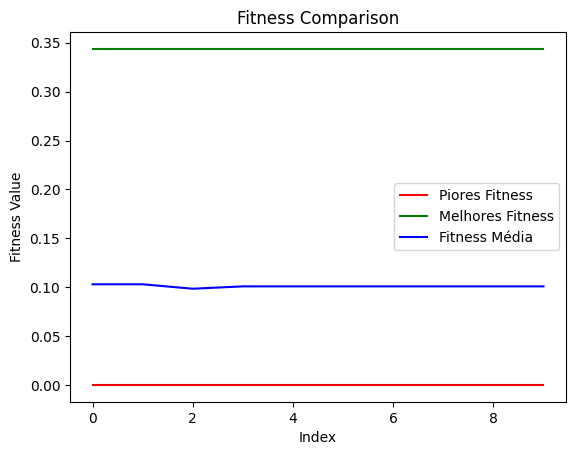

In [ ]:
# Plotting each array
plt.plot(arr_piores_fitness, label='Piores Fitness', color='red')
plt.plot(arr_melhores_fitness, label='Melhores Fitness', color='green')
plt.plot(arr_fitness_media, label='Fitness Média', color='blue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Fitness Value')
plt.title('Fitness Comparison')

# Adding a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()

In [ ]:
for i in range(pop.get_tam_pop()):
    ind = pop._populacao[i][0]
    v_score_test = ind.fitness(X_test, y_test)
    v_score_train = ind.fitness(X_train, y_train)
    print(f"{ind.fenotipo} - diff fitness: {v_score_train -v_score_test:.3f}")
    """ print(f"V-Score Train: {v_score_train}")
    print(f"V-Score Test: {v_score_test}") """
    

dx[3]-1*(dx[7]-dx[2]) - diff fitness: 0.312
dx[5] - diff fitness: 0.067
SafeMath.sqrt(dx[7])+dx[3]*dx[8]+dx[2]+dx[7] - diff fitness: 0.066
dx[7] - diff fitness: 0.118
dx[3]-dx[4]+6*(dx[1])*SafeMath.pow2(3*(dx[3])) - diff fitness: 0.054
dx[3] - diff fitness: 0.082
dx[8] - diff fitness: 0.126
SafeMath.pow2(SafeMath.sqrt(dx[0])*SafeMath.log(dx[7])) - diff fitness: 0.021
SafeMath.log(dx[1]+dx[4])+SafeMath.pow2(dx[2])+SafeMath.pow2(dx[4]) - diff fitness: 0.199
dx[1] - diff fitness: 0.012
dx[0] - diff fitness: -0.016
dx[5] - diff fitness: 0.067
dx[8] - diff fitness: 0.126
4*(dx[7]-dx[8]+dx[2]) - diff fitness: 0.050
SafeMath.pow2(dx[3]) - diff fitness: 0.082
dx[8] - diff fitness: 0.126
SafeMath.log(dx[7]) - diff fitness: 0.118
dx[7] - diff fitness: 0.118
SafeMath.log(dx[3]) - diff fitness: 0.082
8*(SafeMath.log(dx[2]))*SafeMath.inv(dx[7]*dx[2]) - diff fitness: 0.004
dx[2] - diff fitness: 0.199
1*(dx[7]*dx[4]+dx[5]) - diff fitness: 0.109
SafeMath.pow2(dx[7]-dx[1])+dx[2] - diff fitness: 0.118
S

In [ ]:
pop.get_melhor_individuo()[0].fenotipo

'dx[3]-1*(dx[7]-dx[2])'